In [120]:
import json
import openeo
from openeo.processes import lte
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
import rasterio
import xarray as xr
import os
import zipfile
import glob

from utils import openeoMap, OnnxInference, PowerScalers, reproject_bbox, optimize_compression, download_from_artifactory


# Authentication

Authenticate through the Terrascope platform.
If you don't have a Terrascope account already create one for free at https://portal.terrascope.be/

In [2]:
# Connect and authenticate
connection = openeo.connect("openeo.vito.be").authenticate_oidc(provider_id='terrascope')

Authenticated using refresh token.


# Execute CORSA compression

Select a region and time interval to run the compression model on the Terrascope servers. <br>
The compressed images take up less disk space by a factor around 32.

This service can also be launched from the Terrascope portal in a no-code environment. <br>
https://portal.terrascope.be/catalogue/app-details/120

## Region selection

In [3]:
# draw a bounding box on the map to select your area of interest
# you can uncheck the imagery layer to see the underlying map

eoMap = openeoMap(center=[50.84, 4.35], zoom=11)
eoMap.map


Map(center=[50.84, 4.35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [4]:
bbox = eoMap.getBbox()
print('Current spatial bounding box specified in longitude/latitude:', np.round(bbox,2))


Current spatial bounding box specified in longitude/latitude: [ 4.84 50.21  4.99 50.28]


In [5]:
# it might be useful to reproject the bounding box to local utm coords
# not strictly necessary, but it might avoid problems at the edge of the region
bbox, crs_epsg = reproject_bbox(bbox)
print(f'New spatial bounding box specified in epsg {crs_epsg}: {np.round(bbox,2)}')

spatial_extent = dict(zip(["west", "south", "east", "north"], bbox))
spatial_extent["crs"] = crs_epsg


New spatial bounding box specified in epsg 32631: [ 631120. 5563080.  641480. 5571760.]


## Date selection

In [6]:
# select date to process. Expressed as an interval, all dates for which data is available will be processed.
year = 2021
month = 9

startdate = "{}-{:02d}-{:02d}".format(year, month, 1)
enddate = "{}-{:02d}-{:02d}".format(year, month, 16)
temporal_extent = [startdate, enddate]

print('All dates with data availability will be processed within the interval:', temporal_extent)

All dates with data availability will be processed within the interval: ['2021-09-01', '2021-09-16']


## Execute

In [7]:
# scale up when processing larger regions
job_options = {
    "executor-memory": "2G",
    "executor-memoryOverhead": "4G",
    "executor-cores": "2",
}

In [24]:
inference_result = connection.datacube_from_process(
    process_id="corsa_compression",
    spatial_extent=spatial_extent,
    namespace="vito",
    temporal_extent = temporal_extent)

try:
    job = inference_result.create_job(job_options=job_options,title="corsa_compression")
    job.start_and_wait()
except Exception as e:
    print('Error in job submission:', e)
    print('Job status:', job.status())
    if job.status() == 'error':
        errors = job.logs(level='error')
        for er in errors:
            print('ERROR: ', er.message)
        
    print("\nInspect full logs by typing 'job.logs()' in the cell below")


0:00:00 Job 'j-240821bed9864d618d78b1c76e1f9434': send 'start'
0:00:23 Job 'j-240821bed9864d618d78b1c76e1f9434': queued (progress 0%)
0:00:29 Job 'j-240821bed9864d618d78b1c76e1f9434': queued (progress 0%)
0:00:35 Job 'j-240821bed9864d618d78b1c76e1f9434': queued (progress 0%)
0:00:43 Job 'j-240821bed9864d618d78b1c76e1f9434': queued (progress 0%)
0:00:53 Job 'j-240821bed9864d618d78b1c76e1f9434': queued (progress 0%)
0:01:05 Job 'j-240821bed9864d618d78b1c76e1f9434': queued (progress 0%)
0:01:21 Job 'j-240821bed9864d618d78b1c76e1f9434': running (progress N/A)
0:01:40 Job 'j-240821bed9864d618d78b1c76e1f9434': running (progress N/A)
0:02:04 Job 'j-240821bed9864d618d78b1c76e1f9434': running (progress N/A)
0:02:34 Job 'j-240821bed9864d618d78b1c76e1f9434': running (progress N/A)
0:03:11 Job 'j-240821bed9864d618d78b1c76e1f9434': running (progress N/A)
0:03:58 Job 'j-240821bed9864d618d78b1c76e1f9434': running (progress N/A)
0:04:57 Job 'j-240821bed9864d618d78b1c76e1f9434': running (progress N/A)


In [ ]:
outputs = job.get_results()
outputs.get_metadata()

In [26]:
# download results
# output format is level{X}_{resolution}m_{date}Z.tif

outputs.download_files('./corsa_compression')

[PosixPath('corsa_compression_V2_dinant/level0_20m_2021-09-02Z.tif'),
 PosixPath('corsa_compression_V2_dinant/level0_20m_2021-09-04Z.tif'),
 PosixPath('corsa_compression_V2_dinant/level0_20m_2021-09-07Z.tif'),
 PosixPath('corsa_compression_V2_dinant/level1_40m_2021-09-02Z.tif'),
 PosixPath('corsa_compression_V2_dinant/level1_40m_2021-09-04Z.tif'),
 PosixPath('corsa_compression_V2_dinant/level1_40m_2021-09-07Z.tif'),
 PosixPath('corsa_compression_V2_dinant/result.json'),
 PosixPath('corsa_compression_V2_dinant/job-results.json')]

# Local reconstruction

We use the publicly available decoder to inspect some of the reconstructed images.


In [59]:
# download decoder from vito artifactory
artifactory = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/openeo/corsa-compression"

download_from_artifactory("decoding.zip", out_path="./decoding.zip", artifactory=artifactory)

 decoding.zip downloaded


In [60]:
# unzip to corsa_compression directory
with zipfile.ZipFile('./decoding.zip', 'r') as zip_ref:
    zip_ref.extractall('./corsa_compression')

In [130]:
# load the compressed indices, both level0 (20m) and level1 (40m) are required
date = '2021-09-04'
l0_path = f'corsa_compression/level0_20m_{date}Z.tif'
l1_path = f'corsa_compression/level1_40m_{date}Z.tif'
ids_l0 = rasterio.open(l0_path).read()[0]
ids_l1 = rasterio.open(l1_path).read()[0]

In [131]:
# to avoid boundary problems, we crop the shape of level 0 to a multiple of 60 and level 1 to a multiple of 30
print('original shape', ids_l0.shape, ids_l1.shape)

ids_l0 = ids_l0[:ids_l0.shape[0]//60*60, :ids_l0.shape[1]//60*60]
ids_l1 = ids_l1[:ids_l1.shape[0]//30*30, :ids_l1.shape[1]//30*30]
print('new shape', ids_l0.shape, ids_l1.shape)

original shape (434, 518) (217, 259)
new shape (420, 480) (210, 240)


Text(0.5, 1.0, 'Level 1 indices')

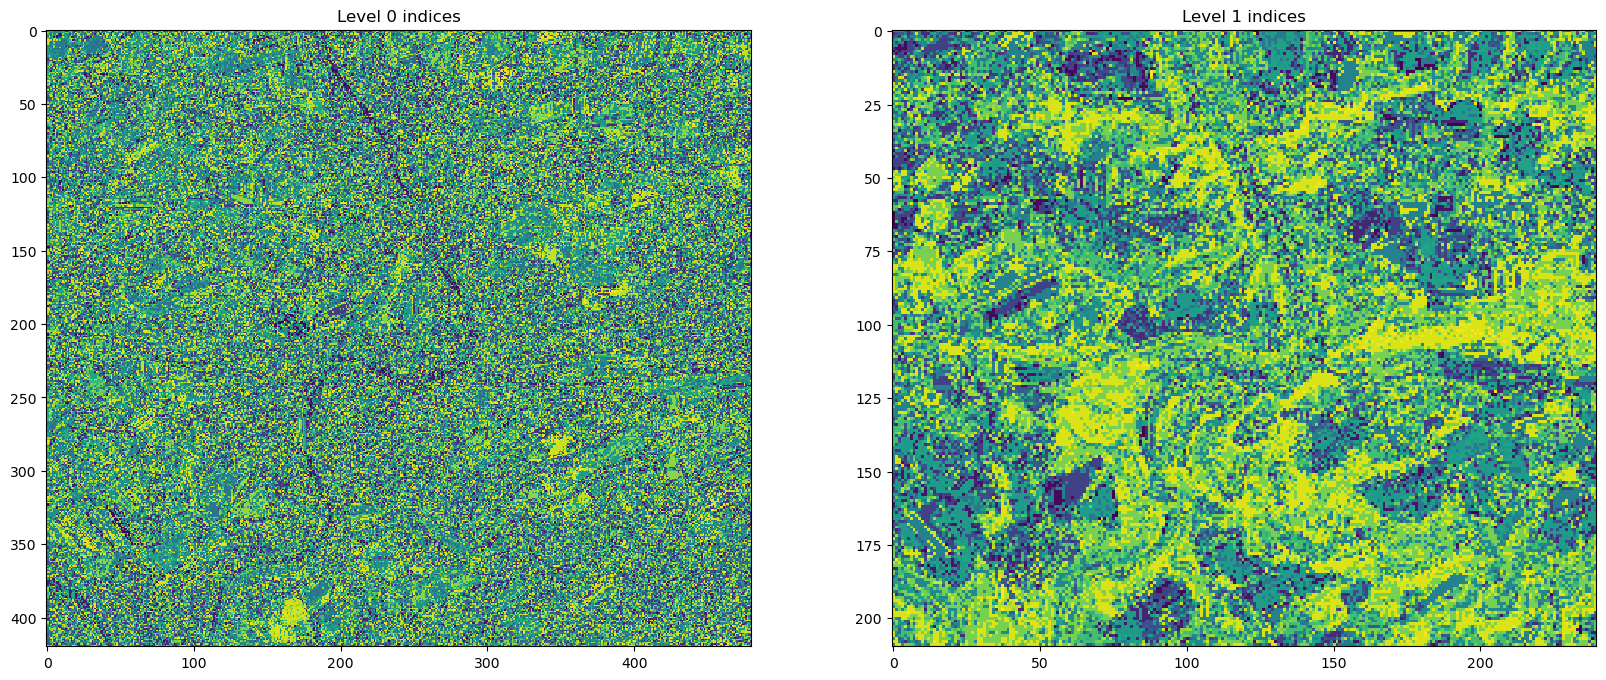

In [132]:
# Visualise level 0, and level 1 indices
# The indices are integers and hard to interpret like this

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(ids_l0, interpolation='nearest')
ax1.set_title('Level 0 indices')
ax2.imshow(ids_l1, interpolation='nearest')
ax2.set_title('Level 1 indices')

In [133]:
# replace nans by 0 (if any)
ids_l0 = np.nan_to_num(ids_l0)
ids_l1 = np.nan_to_num(ids_l1)

In [134]:
# let the decoder do its work

recon = OnnxInference().recon('./corsa_compression/decoder.onnx',ids_l0, ids_l1)



processing patches 7 by 8 ...


  0%|          | 0/56 [00:00<?, ?it/s]

In [135]:
# the model was trained on normalised Sentinel-2 images. So we need to scale the reconstruction back to the orignal range
bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]

ps = PowerScalers(path_to_scalers='./corsa_compression/scalers', bands=bands)
recon_unscaled = ps.unscale(recon, bands=bands)

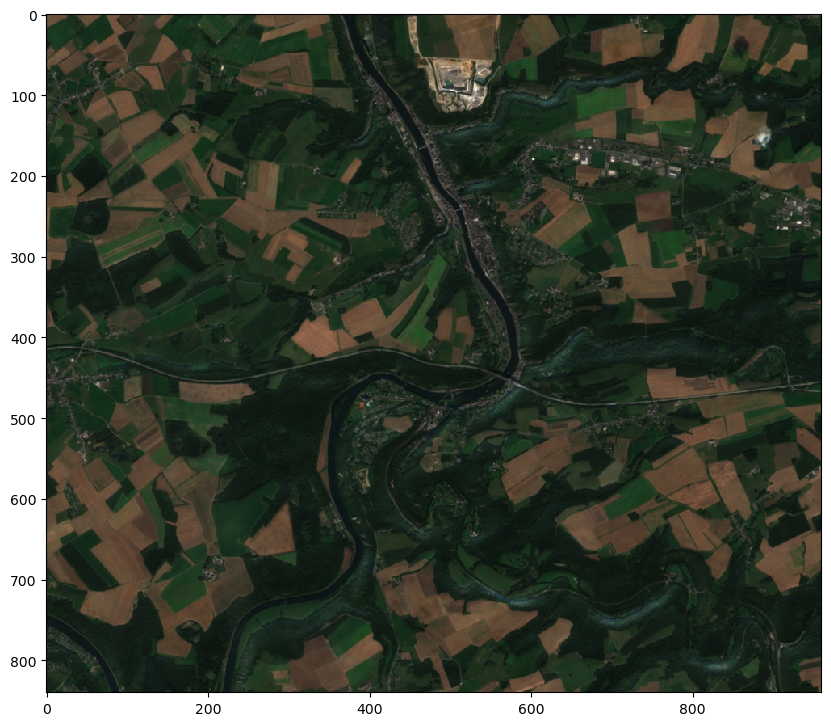

In [136]:
plt.figure(figsize=(10,10))
rgb = np.clip(recon_unscaled[[2,1,0]]/4000,0,1).transpose(1,2,0)
plt.imshow(rgb, interpolation='nearest')

# Compare to original

By downloading the original Sentinel-2 images, we can compare them with the compressed images. <br>
The model was trained on the BigEarthNet dataset which contains mainly cloudfree Sentinel-2 images. <br>
For this reason, reconstruction quality of clouds might be suboptimal still.

In [19]:
collection = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=temporal_extent,
    spatial_extent=spatial_extent,
    bands= bands,
    properties ={ "eo:cloud_cover": lambda cc:lte(cc, 10 )}
)

collection.download('./corsa_compression/original.nc', format='netCDF')

In [74]:
# open the original data
original = xr.open_dataset('./corsa_compression/original.nc').sel(t=date)[bands].to_array().values
original = original[:,:recon_unscaled.shape[1],:recon_unscaled.shape[2]]
rgb_original = np.clip(original[[2,1,0]]/4000,0,1).transpose(1,2,0)

# calculate ndvi
ndvi_original = (original[bands.index('B08')] - original[bands.index('B04')]) / (original[bands.index('B08')] + original[bands.index('B04')])
ndvi_recon = (recon_unscaled[bands.index('B08')] - recon_unscaled[bands.index('B04')]) / (recon_unscaled[bands.index('B08')] + recon_unscaled[bands.index('B04')])

nan_sum = np.isnan(original).sum()
if nan_sum > 0:
    print(f'Warning: {nan_sum} NaN values found in original data')
    print('Small gaps in the data will be interpolated, larger gaps will be left as is. This might affect reconstruction quality locally.')


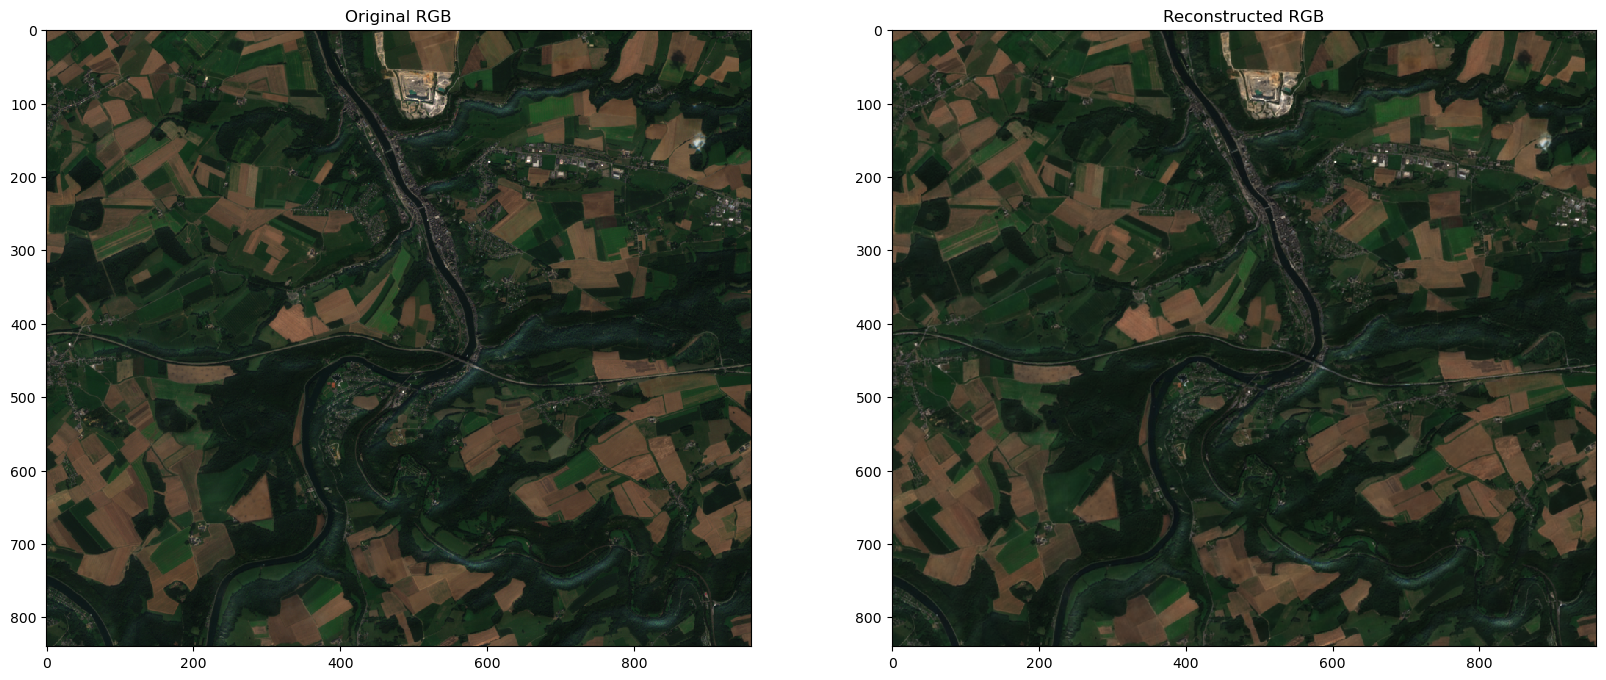

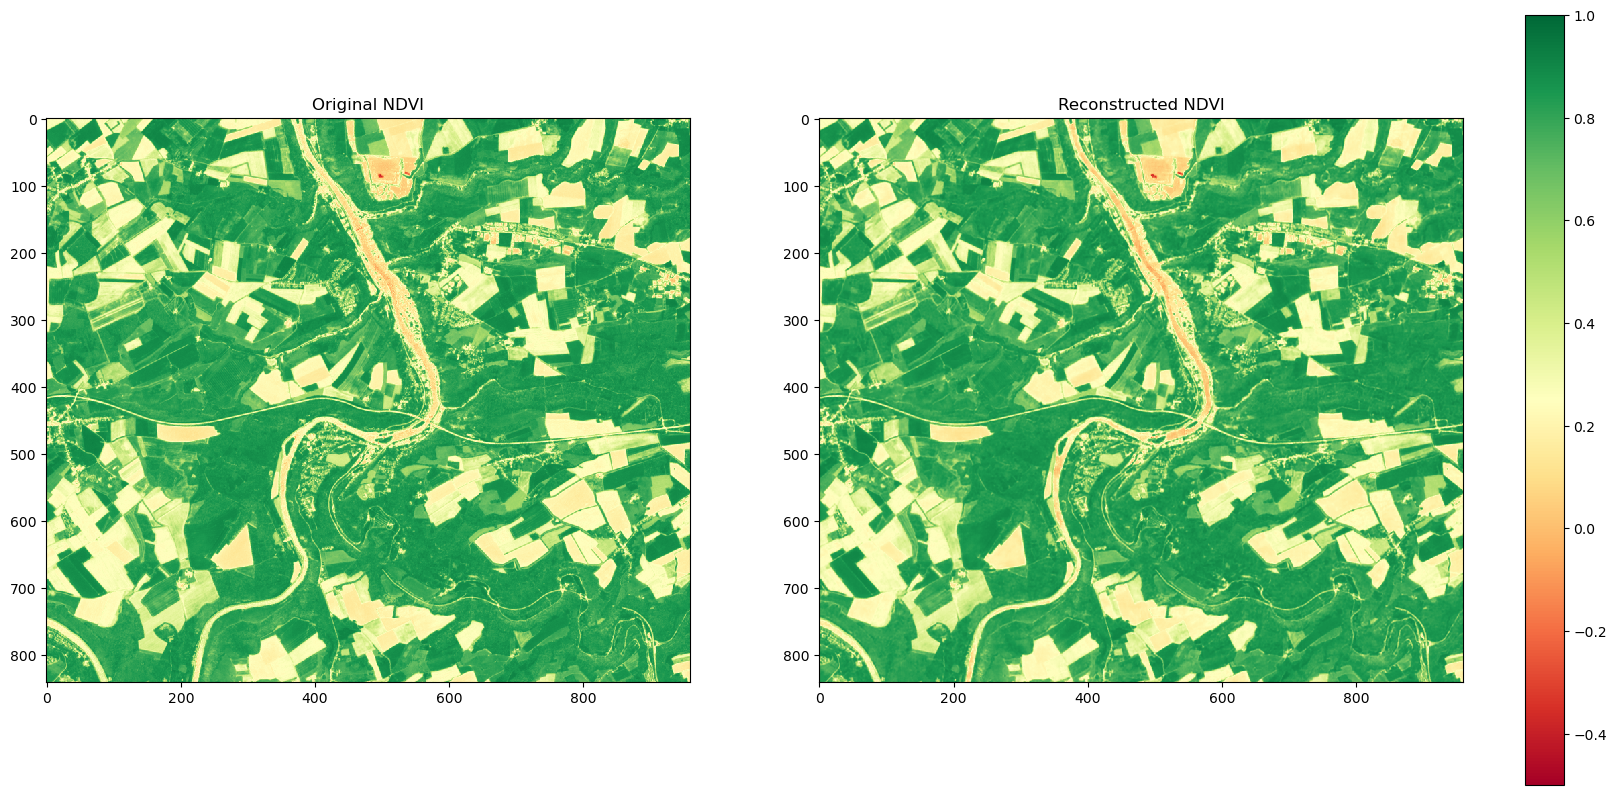

In [126]:
# visualise the original RGB and NDVI next to the reconstructed image

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(rgb_original, interpolation='nearest')
ax2.imshow(rgb, interpolation='nearest')

ax1.set_title('Original RGB')
ax2.set_title('Reconstructed RGB')


fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(20, 10))
plot_ndvi_orig = ax3.imshow(ndvi_original, interpolation='nearest', cmap='RdYlGn', vmax=1, vmin=-0.5)
plot_ndvi_recon = ax4.imshow(ndvi_recon, interpolation='nearest', cmap='RdYlGn',  vmax=1, vmin=-0.5)
ax3.set_title('Original NDVI')
ax4.set_title('Reconstructed NDVI')


fig.colorbar(plot_ndvi_orig, ax=[ax3,ax4], fraction=0.046, pad=0.04)


PSNR: 57.31 dB
MAE: 58.81


Text(0.5, -0.05, 'PSNR: 57.31 dB - MAE: 58.81')

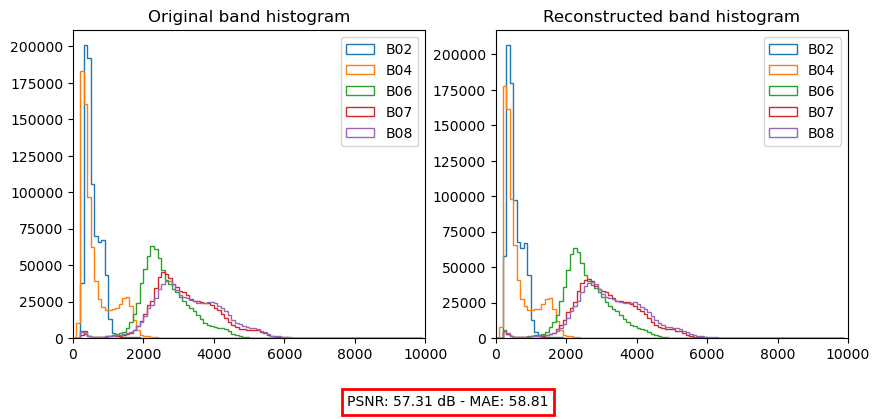

In [106]:
# compare histogram of selected bands and print metrics

metric_psnr = psnr(original, recon_unscaled,data_range=2**16)
metric_mae = np.nanmean(np.abs(original - recon_unscaled))

band_selection = [0,2,4,5,6]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
for k,b in enumerate(band_selection):
    ax1.hist(original[b].flatten(), bins=range(0,10000,100), histtype='step', label=bands[b])
    ax2.hist(recon_unscaled[b].flatten(), bins=range(0,10000,100), histtype='step', label=bands[b])

ax1.set_xlim([0,10000])
ax2.set_xlim([0,10000])
ax1.set_title(f'Original band histogram')
ax2.set_title(f'Reconstructed band histogram')
ax1.legend()
ax2.legend()


print(f'PSNR: {metric_psnr:.2f} dB')
print(f'MAE: {metric_mae:.2f}')
s = f'PSNR: {metric_psnr:.2f} dB - MAE: {metric_mae:.2f}'
fig.text(0.5,-0.05, s, bbox=dict(fill=False, edgecolor='red', linewidth=2), verticalalignment='center',  horizontalalignment='center')

In [107]:
# Calculate compression ratio

original_size  = os.path.getsize("./corsa_compression/original.nc")
embeddings_p = glob.glob('corsa_compression/level*.tif')
total_size = 0

for p in embeddings_p:
    optimize_compression(p)
    total_size += os.path.getsize(p)
    print(p, 'has size of', round(os.path.getsize(p)/1024/1024,4), 'MB')

print(f'''
Original size:  {round(original_size/1024/1024,2)} MB
Current size:   {round(total_size/1024/1024,2)} MB
Compression:    {round(original_size/total_size,2)} times smaller
''')


corsa_compression_V2_dinant/level1_40m_2021-09-04Z.tif has size of 0.0328 MB
corsa_compression_V2_dinant/level1_40m_2021-09-07Z.tif has size of 0.0344 MB
corsa_compression_V2_dinant/level0_20m_2021-09-02Z.tif has size of 0.2797 MB
corsa_compression_V2_dinant/level1_40m_2021-09-02Z.tif has size of 0.0393 MB
corsa_compression_V2_dinant/level0_20m_2021-09-04Z.tif has size of 0.2704 MB
corsa_compression_V2_dinant/level0_20m_2021-09-07Z.tif has size of 0.2409 MB

Original size:  23.7 MB
Current size:   0.9 MB
Compression:    26.4 times smaller



# Downstream application

The compressed indices are not only good for storing high volume datasets, they are excellent to use in downstream AI applications. By mapping the indices back to the codebook vectors, we get high dimensional features containing all the information about the image. New AI models can be efficiently trained directly on top of these features for e.g. change detection, landcover classification, etc.

In this demo we use a simple pretrained landcover classification model to inference on the compressed image.

In [108]:
# load the compressed indices, both level0 (20m) and level1 (40m) are required

ids_l0 = rasterio.open(l0_path).read()[0]
ids_l1 = rasterio.open(l1_path).read()[0]
print('shape of level 0 and level 1 indices', ids_l0.shape, ids_l1.shape)

shape of level 0 and level 1 indices (434, 518) (217, 259)


In [109]:
# the codebook is a dictionary that maps the indices (integers) back to the codebook vector (vector of dimension 128)

codebook_path = './corsa_compression/codebook_vectors.json'
with open(codebook_path) as f:
    codebook = json.load(f)
    codebook = {k: {int(kk): tuple(vv) for kk, vv in v.items()} for k, v in codebook.items()}

print(codebook.keys())
print('The shape of first level0 codebook vector is', np.array(codebook['level0'][0]).shape)

dict_keys(['level0', 'level1'])
The shape of first level0 codebook vector is (128,)


In [110]:
# write a function that maps an array of indices (the compressed files) back to an array of codebook vectors (inputs to the deep learning model)

def map_indices_to_codebook(indices, codebook):
    vec = np.zeros((128,) + indices.shape, dtype=np.float32)
    for i in range(0, indices.shape[0]):
        for j in range(0, indices.shape[1]):
            vec[:,i,j] = codebook.get(indices[i,j], np.nan)
    return vec

In [111]:
vec_l0 = map_indices_to_codebook(ids_l0, codebook['level0'])
vec_l1 = map_indices_to_codebook(ids_l1, codebook['level1'])

In [112]:
print('original shape', vec_l0.shape, vec_l1.shape)
vec_l0 = vec_l0[:,:vec_l0.shape[-2]//60*60, :vec_l0.shape[-1]//60*60]
vec_l1 = vec_l1[:,:vec_l1.shape[-2]//30*30, :vec_l1.shape[-1]//30*30]
print('cropped shape', vec_l0.shape, vec_l1.shape)

original shape (128, 434, 518) (128, 217, 259)
cropped shape (128, 420, 480) (128, 210, 240)


In [113]:
model_path = './corsa_compression/landcover_head.onnx'
preds = OnnxInference().lc(model_path, vec_l0, vec_l1)
preds = np.argmax(preds.squeeze(), axis=0)

processing patches 7 by 8 ...


  0%|          | 0/56 [00:00<?, ?it/s]

In [114]:
# Define colors for the landcover classes

lc_classes = {0:'Water',1:'Trees',2:'Grass',3:'Flooded vegetation',4:'Crops', 5:'Scrub',6:'Built Area',7:'Bare', 8:'Snow/Ice',9:'Cloud'}
lc_color_map = {0:'blue',1:'green',2:'lime',3:'cyan',4:'peru', 5:'olive',6:'red',7:'yellow',8:'white',9:'grey'}
cmap = (matplotlib.colors.ListedColormap(lc_color_map.values()))
norm = matplotlib.colors.Normalize(vmin=0, vmax=9)
patches = [matplotlib.patches.Patch(color=cmap(norm(u)), label=lc_classes[u]) for u in np.unique(preds)]



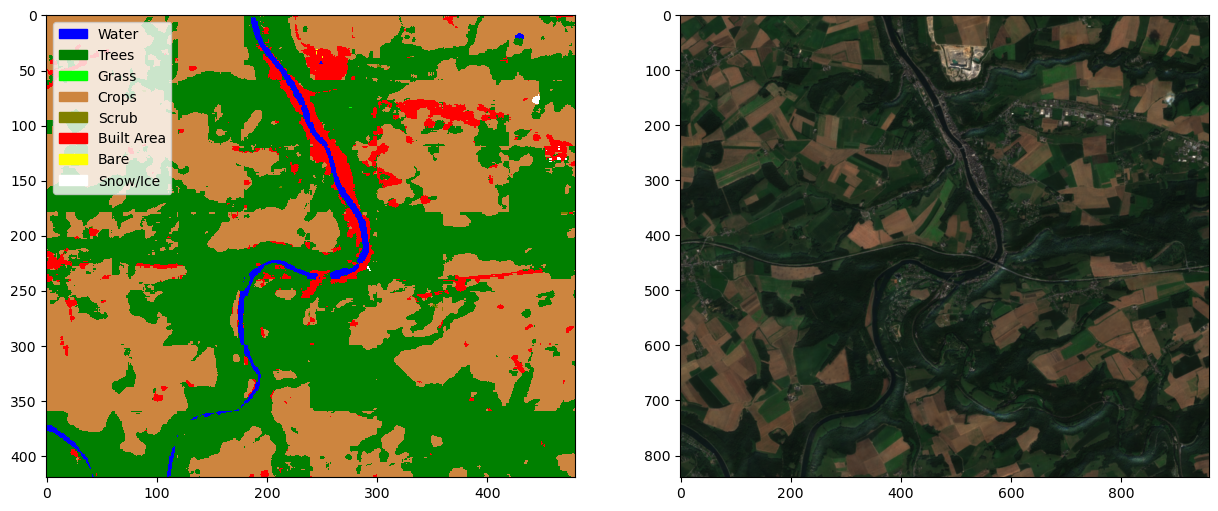

In [115]:
# Result of landcover prediction with the compressed image as input
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.imshow(preds,cmap=cmap, vmin=0, vmax=10, interpolation='nearest')
ax2.imshow(rgb)
ax1.legend(handles=patches, loc='upper left')